In [1]:
import os
import csv
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
from scipy import interpolate

In [3]:
from prettytable import PrettyTable

In [4]:
# Changing Directory
os.chdir("D:\dataset")

## Train set

In [5]:
# Reading Data
df = pd.read_csv('train.csv')
df.head()

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,14,fdfae6789b787899f1b875de3ab8b21a,1,u_Vh1OPkFv3q5CFdR,windows_ie,180.107.112.*,80,85,...,60,1,0,5,612599432d200b093719dd1f372f7a30,300,54,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063"
1,0,2,20,372883147cdefbc495fb5082f79dde9b,1,u_VhkRL6dCOTLsq-c,windows_chrome,125.120.199.*,94,95,...,250,1,0,5,8dff45ed862a740986dbe688aafee7e5,249,42,15b749127478946f161a54dc0dad27c8,3476,"10063,10111"
2,0,5,9,2912cb5947e1fad450e2473c2f61ef75,1,u_VhkyORMrD8TP3GL,windows_ie,120.196.64.*,216,217,...,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,76,bebefa5efe83beee17a3d245e7c5085b,1458,10063
3,0,2,20,d7b7d61d1e50e1d27d210928d28a9b61,1,u_VhkyLRqVL2a4eWL,windows_ie,219.131.122.*,216,221,...,90,0,0,162,7184c9560e68e977187e67e45a4f3198,238,182,0f951a030abdaedd733ee8d114ce2944,3427,"10077,10111"
4,0,6,9,657d317dc4045bb79c2652abbea07530,1,u_Vh1zOJuQOtTCBgL,windows_chrome,123.190.78.*,40,48,...,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,34,a3becb967c015e9acb5e72f22b100ef8,3476,"10031,13042,10006,10057,13866,10063,14273,1005..."


## Selecting Wanted Features

In [6]:
# Define our features
features = ["click", "weekday", "hour", "city", "slotwidth", 'slotheight', 'useragent', 'payprice', 'bidprice', 'slotformat', 'advertiser']
df = df[features]
df = df.dropna()

In [7]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [8]:
df.head()

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,1,14,85,windows_ie,54,300,0,1458,28080
1,0,2,20,95,windows_chrome,42,249,0,3476,62500
2,0,5,9,217,windows_ie,76,300,1,1458,94080
3,0,2,20,221,windows_ie,182,238,0,3427,65520
4,0,6,9,48,windows_chrome,34,238,1,3476,85500


## Labeling and Categorising Data

Categorising:
- Hour: 
    - 0:00~07:59 : 1
    - 08:00~15:59: 2
    - 16:00~23:59: 3
- Size:
    - 0~40000     : 1
    - 40000~80000 : 2
    - 80000~120000: 3

In [9]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
df.head()  

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,1,2,85,windows_ie,54,300,0,1458,1
1,0,2,3,95,windows_chrome,42,249,0,3476,2
2,0,5,2,217,windows_ie,76,300,1,1458,3
3,0,2,3,221,windows_ie,182,238,0,3427,2
4,0,6,2,48,windows_chrome,34,238,1,3476,3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697738 entries, 0 to 2697737
Data columns (total 10 columns):
click         int64
weekday       int64
hour          category
city          int64
useragent     object
payprice      int64
bidprice      int64
slotformat    object
advertiser    int64
slotsize      category
dtypes: category(2), int64(6), object(2)
memory usage: 190.4+ MB


In [11]:
df = df.dropna()
df.isnull().any().any()

False

In [12]:
from sklearn import preprocessing

# Set the random seed
np.random.seed(12)

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

### Dummy Coding

In [13]:
df["click"] = label_encoder.fit_transform(df["click"])
df["weekday"] = label_encoder.fit_transform(df["weekday"])
df["city"] = label_encoder.fit_transform(df["city"])

df["hour"] = label_encoder.fit_transform(df["hour"])
df["slotsize"] = label_encoder.fit_transform(df["slotsize"])
df["slotformat"] = label_encoder.fit_transform(df["slotformat"])
df["advertiser"] = label_encoder.fit_transform(df["advertiser"])

In [14]:
df.head()

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,1,1,84,windows_ie,54,300,0,0,0
1,0,2,2,94,windows_chrome,42,249,0,8,1
2,0,5,1,211,windows_ie,76,300,1,0,2
3,0,2,2,215,windows_ie,182,238,0,7,1
4,0,6,1,48,windows_chrome,34,238,1,8,2


In [15]:
df.useragent.value_counts()

windows_ie          1619590
windows_chrome       885179
android_safari        67728
mac_safari            41409
windows_firefox       24765
windows_theworld      15305
windows_other         12461
mac_other              8700
windows_maxthon        8075
windows_opera          2434
mac_chrome             2119
android_other          1956
other_other            1788
windows_safari         1727
linux_chrome           1060
mac_firefox             844
android_chrome          510
android_opera           504
ios_safari              433
linux_firefox           413
linux_safari            133
other_opera             126
linux_other              64
other_safari             63
mac_maxthon              35
android_maxthon          35
ios_other                31
other_ie                 28
linux_opera              20
linux_ie                 19
mac_opera                18
android_firefox          18
android_sogou            15
mac_sogou                14
other_chrome             13
android_ie          

In [16]:
from collections import Counter

In [17]:
len(df.copy().useragent.tolist())

2697646

In [18]:
def useragent_processing(df):
    df_copy = df.copy()
    
    current_attributes = df_copy.useragent.tolist()
    useragent_processing_platform = [0] * len(current_attributes)
        
    for i in range(len(current_attributes)):
        if (current_attributes[i] == 'windows_ie' or\
            current_attributes[i] == 'windows_chrome' or\
            current_attributes[i] == 'windows_firefox' or\
            current_attributes[i] == 'windows_theworld' or\
            current_attributes[i] == 'windows_other' or\
            current_attributes[i] == 'windows_maxthon' or\
            current_attributes[i] == 'windows_opera' or\
            current_attributes[i] == 'windows_safari' or\
            current_attributes[i] == 'windows_sogou'):
            useragent_processing_platform[i] = 0 # windows
            
        elif (current_attributes[i] == 'android_safari' or\
              current_attributes[i] == 'android_other' or\
              current_attributes[i] == 'android_chrome' or\
              current_attributes[i] == 'android_opera' or\
              current_attributes[i] == 'android_maxthon' or\
              current_attributes[i] == 'android_firefox' or\
              current_attributes[i] == 'android_sogou' or\
              current_attributes[i] == 'android_ie'):
            useragent_processing_platform[i] = 1 # android
            
        elif (current_attributes[i] == 'mac_safari' or\
              current_attributes[i] == 'mac_other' or\
              current_attributes[i] == 'mac_chrome' or\
              current_attributes[i] == 'mac_firefox' or\
              current_attributes[i] == 'mac_maxthon' or\
              current_attributes[i] == 'mac_opera' or\
              current_attributes[i] == 'mac_sogou' or\
              current_attributes[i] == 'mac_ie'):
            useragent_processing_platform[i] = 2 # mac
            
        elif (current_attributes[i] == 'linux_chrome' or\
              current_attributes[i] == 'linux_firefox' or\
              current_attributes[i] == 'linux_safari' or\
              current_attributes[i] == 'linux_other' or\
              current_attributes[i] == 'linux_opera' or\
              current_attributes[i] == 'linux_ie'):
            useragent_processing_platform[i] = 3 # linux
            
        elif (current_attributes[i] == 'ios_safari' or\
              current_attributes[i] == 'ios_other'):
            useragent_processing_platform[i] = 4 # ios
            
        elif (current_attributes[i] == 'other_other' or\
              current_attributes[i] == 'other_opera' or\
              current_attributes[i] == 'other_safari' or\
              current_attributes[i] == 'other_ie' or\
              current_attributes[i] == 'other_chrome' or\
              current_attributes[i] == 'other_firefox'):
            useragent_processing_platform[i] = 5 # other
            
        else:
            useragent_processing_platform[i] = 6 # for sanity check
        
    return useragent_processing_platform

In [19]:
useragent_processing_platform = useragent_processing(df)

In [20]:
Counter(useragent_processing_platform)

Counter({0: 2569540, 1: 70774, 2: 53140, 3: 1709, 4: 464, 5: 2019})

In [21]:
df_index = df.index.get_values()

In [22]:
def dummy_coding(df):
    df_copy = df.copy()
    
    windows_true = [0] * len(useragent_processing_platform)
    android_true = [0] * len(useragent_processing_platform)
    mac_true = [0] * len(useragent_processing_platform)
    linux_true = [0] * len(useragent_processing_platform)
    ios_true = [0] * len(useragent_processing_platform)
    other_true = [0] * len(useragent_processing_platform)
    
    for i in range(len(useragent_processing_platform)):
        if useragent_processing_platform[i] == 0:
            windows_true[i] = 1
        elif useragent_processing_platform[i] == 1:
            android_true[i] = 1
        elif useragent_processing_platform[i] == 2:
            mac_true[i] = 1
        elif useragent_processing_platform[i] == 3:
            linux_true[i] = 1
        elif useragent_processing_platform[i] == 4:
            ios_true[i] = 1
        elif useragent_processing_platform[i] == 5:
            other_true[i] = 1
    
    windows_true_array = np.asarray(windows_true)
    df['agent_windows'] = pd.Series(windows_true_array, index = df_index)
    
    android_true_array = np.asarray(android_true)
    df['agent_android'] = pd.Series(android_true_array, index = df_index)
    
    mac_true_array = np.asarray(mac_true)
    df['agent_mac'] = pd.Series(mac_true_array, index = df_index)
    
    linux_true_array = np.asarray(linux_true)
    df['agent_linux'] = pd.Series(linux_true_array, index = df_index)
    
    ios_true_array = np.asarray(ios_true)
    df['agent_ios'] = pd.Series(ios_true_array, index = df_index)
    
    other_true_array = np.asarray(other_true)
    df['agent_other'] = pd.Series(other_true_array, index = df_index)
    
    return df

In [23]:
df = dummy_coding(df)

In [24]:
df

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,1,1,84,windows_ie,54,300,0,0,0,1,0,0,0,0,0
1,0,2,2,94,windows_chrome,42,249,0,8,1,1,0,0,0,0,0
2,0,5,1,211,windows_ie,76,300,1,0,2,1,0,0,0,0,0
3,0,2,2,215,windows_ie,182,238,0,7,1,1,0,0,0,0,0
4,0,6,1,48,windows_chrome,34,238,1,8,2,1,0,0,0,0,0
5,0,3,2,6,windows_ie,99,227,1,5,1,1,0,0,0,0,0
6,0,5,2,211,windows_chrome,61,277,3,1,1,1,0,0,0,0,0
7,0,0,2,214,windows_chrome,39,294,3,3,2,1,0,0,0,0,0
8,0,4,2,207,windows_ie,111,300,0,6,2,1,0,0,0,0,0
9,0,0,2,56,windows_ie,30,300,0,0,2,1,0,0,0,0,0


In [25]:
df = df.drop('useragent', axis =1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697646 entries, 0 to 2697737
Data columns (total 15 columns):
click            int64
weekday          int64
hour             int64
city             int64
payprice         int64
bidprice         int64
slotformat       int64
advertiser       int64
slotsize         int64
agent_windows    int32
agent_android    int32
agent_mac        int32
agent_linux      int32
agent_ios        int32
agent_other      int32
dtypes: int32(6), int64(9)
memory usage: 267.6 MB


In [27]:
df.head()

,click,weekday,hour,city,payprice,bidprice,slotformat,advertiser,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,1,1,84,54,300,0,0,0,1,0,0,0,0,0
1,0,2,2,94,42,249,0,8,1,1,0,0,0,0,0
2,0,5,1,211,76,300,1,0,2,1,0,0,0,0,0
3,0,2,2,215,182,238,0,7,1,1,0,0,0,0,0
4,0,6,1,48,34,238,1,8,2,1,0,0,0,0,0


## Validation set

In [28]:
# Reading Data
va_df = pd.read_csv('validation.csv')
va_df.head()

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,14,91c6a6b9e90c0f54d3230815a5a3e22e,1,u_Vhk7C5STO8TZ3s8,windows_ie,14.122.240.*,216,232,...,250,0,1,0,449a22cd91d9042eda3d3a1b89a22ea8,227,102,0f951a030abdaedd733ee8d114ce2944,3427,"10006,10063,10059,10111"
1,0,3,14,24b3621ad3b063b6c09c541781d534b3,1,u_DANDbCAksMy,android_safari,116.22.55.*,216,217,...,50,FirstView,Na,118,11908,277,118,null,2997,null
2,0,1,13,6e7bce0a9ad42f479827d37bf9618a9d,1,u_VhkxPnKHPo1H3Vb,windows_ie,60.215.242.*,146,149,...,90,0,0,70,d01411218cc79bc49d2a4078c4093b76,241,77,b2e35064f3549d447edbbdfb1f707c8c,3427,null
3,0,5,18,6873feca381b8293bf418ba8408a014c,1,u_Vh5zL3B83ln9Xbl,windows_chrome,27.193.87.*,146,148,...,90,0,0,70,c46090c887c257b61ab1fa11baee91d8,241,77,0f951a030abdaedd733ee8d114ce2944,3427,null
4,0,5,14,7e6430333c552cf0b32bb21dc792d2df,1,u_VhKPOr5wOt9HQsj,windows_ie,183.228.214.*,275,275,...,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,178,361e128affece850342293213691a043,3386,null


In [29]:
va_df = va_df[features]
va_df = va_df.dropna()
va_df['slotsize'] = va_df['slotwidth'] * va_df['slotheight'] 
va_df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [30]:
va_df.head()

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,5,14,232,windows_ie,102,227,1,3427,75000
1,0,3,14,217,android_safari,118,277,Na,2997,16000
2,0,1,13,149,windows_ie,77,241,0,3427,90000
3,0,5,18,148,windows_chrome,77,241,0,3427,90000
4,0,5,14,275,windows_ie,178,300,0,3386,94080


In [31]:
va_df['hour'] = pd.cut(va_df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
va_df['slotsize'] = pd.cut(va_df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
va_df.head()  

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize
0,0,5,2,232,windows_ie,102,227,1,3427,2
1,0,3,2,217,android_safari,118,277,Na,2997,1
2,0,1,2,149,windows_ie,77,241,0,3427,3
3,0,5,3,148,windows_chrome,77,241,0,3427,3
4,0,5,2,275,windows_ie,178,300,0,3386,3


In [32]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299749 entries, 0 to 299748
Data columns (total 10 columns):
click         299749 non-null int64
weekday       299749 non-null int64
hour          299749 non-null category
city          299749 non-null int64
useragent     299749 non-null object
payprice      299749 non-null int64
bidprice      299749 non-null int64
slotformat    299749 non-null object
advertiser    299749 non-null int64
slotsize      299745 non-null category
dtypes: category(2), int64(6), object(2)
memory usage: 21.2+ MB


In [33]:
va_df = va_df.dropna()
va_df.isnull().any().any()

False

### Dummy 

In [34]:
va_df["click"] = label_encoder.fit_transform(va_df["click"])
va_df["weekday"] = label_encoder.fit_transform(va_df["weekday"])
va_df["city"] = label_encoder.fit_transform(va_df["city"])

va_df["hour"] = label_encoder.fit_transform(va_df["hour"])
va_df["slotsize"] = label_encoder.fit_transform(va_df["slotsize"])
va_df['slotformat'] = label_encoder.fit_transform(va_df["slotformat"])
va_df['advertiser'] = label_encoder.fit_transform(va_df["advertiser"])

In [35]:
va_df.useragent.value_counts()

windows_ie          180465
windows_chrome       97859
android_safari        7479
mac_safari            4621
windows_firefox       2743
windows_theworld      1662
windows_other         1425
mac_other              956
windows_maxthon        912
windows_opera          300
android_other          239
other_other            214
mac_chrome             210
windows_safari         183
linux_chrome           132
mac_firefox             80
android_chrome          57
ios_safari              52
android_opera           46
linux_firefox           40
linux_safari            24
other_opera              7
linux_other              6
linux_opera              5
mac_maxthon              4
linux_ie                 4
ios_other                3
android_maxthon          3
other_safari             3
mac_opera                3
other_ie                 2
android_firefox          2
other_firefox            1
windows_sogou            1
android_sogou            1
android_ie               1
Name: useragent, dtype: int6

In [36]:
def va_useragent_processing(df):
    df_copy = df.copy()
    
    current_attributes = df_copy.useragent.tolist()
    va_useragent_processing_platform = [0] * len(current_attributes)
        
    for i in range(len(current_attributes)):
        if (current_attributes[i] == 'windows_ie' or\
            current_attributes[i] == 'windows_chrome' or\
            current_attributes[i] == 'windows_firefox' or\
            current_attributes[i] == 'windows_theworld' or\
            current_attributes[i] == 'windows_other' or\
            current_attributes[i] == 'windows_maxthon' or\
            current_attributes[i] == 'windows_opera' or\
            current_attributes[i] == 'windows_safari' or\
            current_attributes[i] == 'windows_sogou'):
            va_useragent_processing_platform[i] = 0 # windows
            
        elif (current_attributes[i] == 'android_safari' or\
              current_attributes[i] == 'android_other' or\
              current_attributes[i] == 'android_chrome' or\
              current_attributes[i] == 'android_opera' or\
              current_attributes[i] == 'android_maxthon' or\
              current_attributes[i] == 'android_firefox' or\
              current_attributes[i] == 'android_sogou' or\
              current_attributes[i] == 'android_ie'):
            va_useragent_processing_platform[i] = 1 # android
            
        elif (current_attributes[i] == 'mac_safari' or\
              current_attributes[i] == 'mac_other' or\
              current_attributes[i] == 'mac_chrome' or\
              current_attributes[i] == 'mac_firefox' or\
              current_attributes[i] == 'mac_maxthon' or\
              current_attributes[i] == 'mac_opera' or\
              current_attributes[i] == 'mac_sogou' or\
              current_attributes[i] == 'mac_ie'):
            va_useragent_processing_platform[i] = 2 # mac
            
        elif (current_attributes[i] == 'linux_chrome' or\
              current_attributes[i] == 'linux_firefox' or\
              current_attributes[i] == 'linux_safari' or\
              current_attributes[i] == 'linux_other' or\
              current_attributes[i] == 'linux_opera' or\
              current_attributes[i] == 'linux_ie'):
            va_useragent_processing_platform[i] = 3 # linux
            
        elif (current_attributes[i] == 'ios_safari' or\
              current_attributes[i] == 'ios_other'):
            va_useragent_processing_platform[i] = 4 # ios
            
        elif (current_attributes[i] == 'other_other' or\
              current_attributes[i] == 'other_opera' or\
              current_attributes[i] == 'other_safari' or\
              current_attributes[i] == 'other_ie' or\
              current_attributes[i] == 'other_chrome' or\
              current_attributes[i] == 'other_firefox'):
            va_useragent_processing_platform[i] = 5 # other
            
        else:
            va_useragent_processing_platform[i] = 6 # for sanity check
        
    return va_useragent_processing_platform

In [37]:
def va_dummy_coding(df):
    df_copy = df.copy()
    
    windows_true = [0] * len(va_useragent_processing_platform)
    android_true = [0] * len(va_useragent_processing_platform)
    mac_true = [0] * len(va_useragent_processing_platform)
    linux_true = [0] * len(va_useragent_processing_platform)
    ios_true = [0] * len(va_useragent_processing_platform)
    other_true = [0] * len(va_useragent_processing_platform)
    
    for i in range(len(va_useragent_processing_platform)):
        if va_useragent_processing_platform[i] == 0:
            windows_true[i] = 1
        elif va_useragent_processing_platform[i] == 1:
            android_true[i] = 1
        elif va_useragent_processing_platform[i] == 2:
            mac_true[i] = 1
        elif va_useragent_processing_platform[i] == 3:
            linux_true[i] = 1
        elif va_useragent_processing_platform[i] == 4:
            ios_true[i] = 1
        elif va_useragent_processing_platform[i] == 5:
            other_true[i] = 1
    
    windows_true_array = np.asarray(windows_true)
    df['agent_windows'] = pd.Series(windows_true_array, index = va_df_index)
    
    android_true_array = np.asarray(android_true)
    df['agent_android'] = pd.Series(android_true_array, index = va_df_index)
    
    mac_true_array = np.asarray(mac_true)
    df['agent_mac'] = pd.Series(mac_true_array, index = va_df_index)
    
    linux_true_array = np.asarray(linux_true)
    df['agent_linux'] = pd.Series(linux_true_array, index = va_df_index)
    
    ios_true_array = np.asarray(ios_true)
    df['agent_ios'] = pd.Series(ios_true_array, index = va_df_index)
    
    other_true_array = np.asarray(other_true)
    df['agent_other'] = pd.Series(other_true_array, index = va_df_index)
    
    return df

In [38]:
len(va_df.copy().useragent.tolist())

299745

In [39]:
va_useragent_processing_platform = va_useragent_processing(va_df)

In [40]:
Counter(va_useragent_processing_platform)

Counter({0: 285550, 1: 7828, 2: 5874, 3: 211, 4: 55, 5: 227})

In [41]:
va_df_index = va_df.index.get_values()

In [42]:
va_df = va_dummy_coding(va_df)

In [43]:
va_df

,click,weekday,hour,city,useragent,payprice,bidprice,slotformat,advertiser,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,226,windows_ie,102,227,1,7,1,1,0,0,0,0,0
1,0,3,1,211,android_safari,118,277,3,4,0,0,1,0,0,0,0
2,0,1,1,148,windows_ie,77,241,0,7,2,1,0,0,0,0,0
3,0,5,2,147,windows_chrome,77,241,0,7,2,1,0,0,0,0,0
4,0,5,1,250,windows_ie,178,300,0,6,2,1,0,0,0,0,0
5,0,1,2,283,windows_chrome,49,238,1,8,1,1,0,0,0,0,0
6,0,3,2,78,windows_ie,52,300,0,6,1,1,0,0,0,0,0
7,0,2,0,349,windows_ie,86,294,3,3,2,1,0,0,0,0,0
8,0,0,0,250,windows_ie,212,254,0,8,1,1,0,0,0,0,0
9,0,0,0,109,windows_chrome,40,300,0,0,1,1,0,0,0,0,0


In [44]:
va_df = va_df.drop('useragent', axis =1)

In [45]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299745 entries, 0 to 299748
Data columns (total 15 columns):
click            299745 non-null int64
weekday          299745 non-null int64
hour             299745 non-null int64
city             299745 non-null int64
payprice         299745 non-null int64
bidprice         299745 non-null int64
slotformat       299745 non-null int64
advertiser       299745 non-null int64
slotsize         299745 non-null int64
agent_windows    299745 non-null int32
agent_android    299745 non-null int32
agent_mac        299745 non-null int32
agent_linux      299745 non-null int32
agent_ios        299745 non-null int32
agent_other      299745 non-null int32
dtypes: int32(6), int64(9)
memory usage: 29.7 MB


In [46]:
va_df.head()

,click,weekday,hour,city,payprice,bidprice,slotformat,advertiser,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,226,102,227,1,7,1,1,0,0,0,0,0
1,0,3,1,211,118,277,3,4,0,0,1,0,0,0,0
2,0,1,1,148,77,241,0,7,2,1,0,0,0,0,0
3,0,5,2,147,77,241,0,7,2,1,0,0,0,0,0
4,0,5,1,250,178,300,0,6,2,1,0,0,0,0,0


## Training Logistic Regression (linear_model.LogisticRegression)

In [47]:
try:
    from sklearn.model_selection import train_test_split, cross_val_score
except ImportError:
    from sklearn.cross_validation import train_test_split, cross_val_score

In [48]:
# Defining X and Y in Train
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [49]:
X_validation = va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y_validation = va_df['click']

### Choose the Estimator
We will use **``linear_model.LogisticRegression()``** from **`sklearn`** module.

In [50]:
# Training the model
logreg = linear_model.LogisticRegression()

In [51]:
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
print(logreg.coef_)
print(logreg.intercept_)

[[ -1.97180573e-02   1.01456555e-01  -4.89020580e-06  -9.21180402e-02
   -1.56609600e-02   4.67941185e-02  -2.37431226e+00  -7.37028856e-02
   -6.30118987e-01  -8.02164176e-01  -1.60684198e-01  -1.02172683e+00]]
[-5.06270934]


### Inspecting Scores of Test Data and Predicting Probability of Test Data

In [53]:
logreg.score(X_validation, Y_validation)

0.99924602578858701

In [54]:
logreg.predict(X_validation)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [55]:
narray = logreg.predict(X_validation)
print(narray.sum())

0


In [56]:
logreg.predict_proba(X_validation)

array([[  9.99494881e-01,   5.05119055e-04],
       [  9.95653981e-01,   4.34601857e-03],
       [  9.99371814e-01,   6.28186339e-04],
       ..., 
       [  9.99301481e-01,   6.98519284e-04],
       [  9.99439778e-01,   5.60222361e-04],
       [  9.99315769e-01,   6.84230939e-04]])

In [57]:
len(logreg.predict_proba(X_validation))

299745

In [58]:
probarray = logreg.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99494881e-01,   5.05119055e-04],
       [  9.95653981e-01,   4.34601857e-03],
       [  9.99371814e-01,   6.28186339e-04],
       ..., 
       [  9.99301481e-01,   6.98519284e-04],
       [  9.99439778e-01,   5.60222361e-04],
       [  9.99315769e-01,   6.84230939e-04]])

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


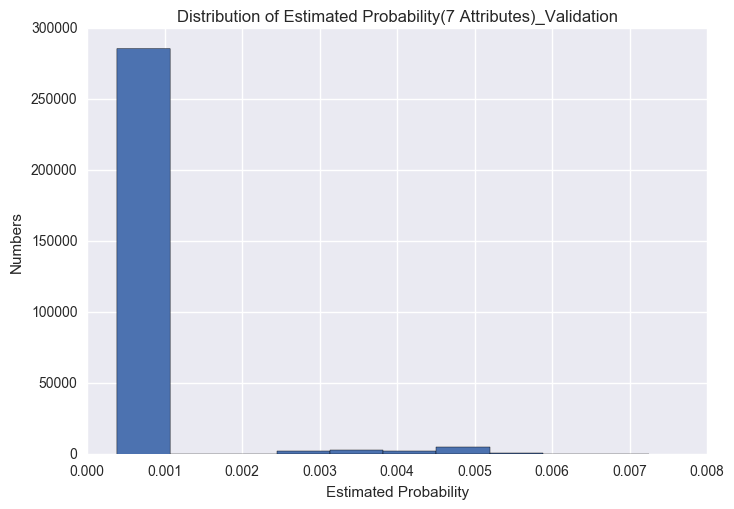

In [59]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
va_df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(7 Attributes)_Validation")
plt.legend()
plt.show()

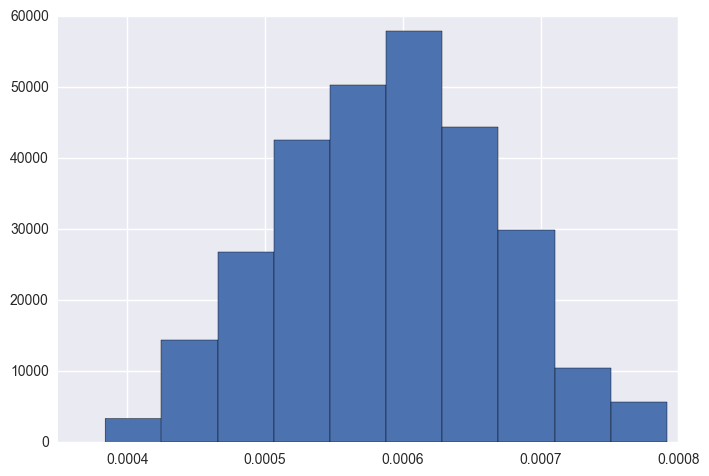

In [60]:
va_df_small = va_df[va_df['log_prob'] < 0.001]
va_df_small['log_prob'].hist()
plt.show()

In [61]:
print(va_df['log_prob'].describe())

count    299745.000000
mean          0.000755
std           0.000776
min           0.000384
25%           0.000540
50%           0.000597
75%           0.000654
max           0.007252
Name: log_prob, dtype: float64


In [62]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


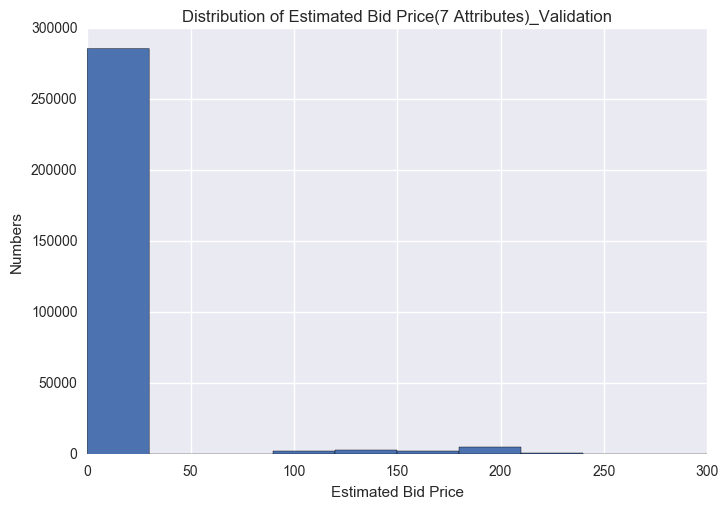

In [63]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation")
plt.legend()
plt.show()

In [64]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean         16.227799
std          33.910835
min           0.000000
25%           6.799121
50%           9.313601
75%          11.810787
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 1149.9447528793687
skewness: 4.673293958062368
kurtosis: 21.43455203461151


In [65]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


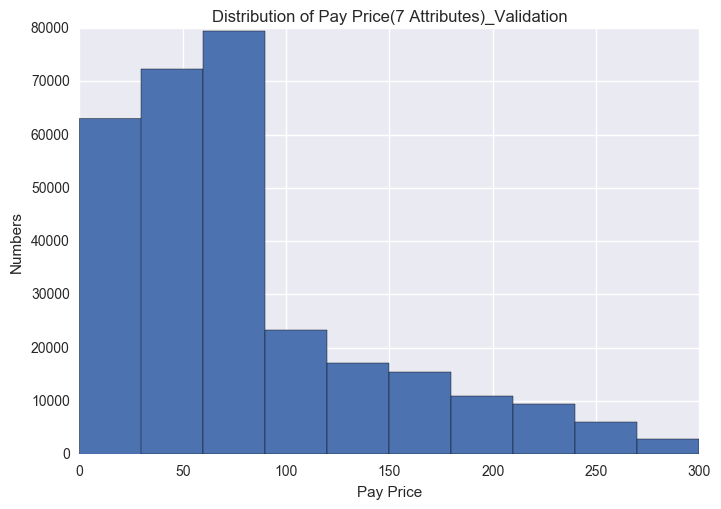

In [66]:
plt.xlabel('Pay Price')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Pay Price(7 Attributes)_Validation")
plt.legend()
plt.show()

In [67]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


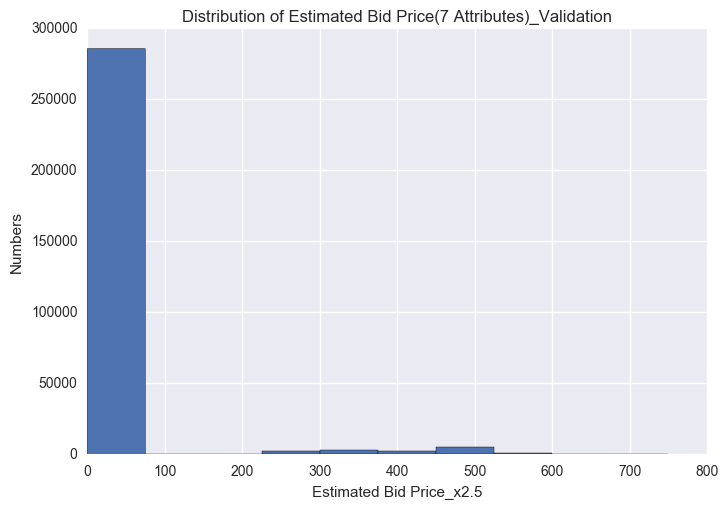

In [68]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation")
plt.legend()
plt.show()

#### Tables

In [69]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

In [70]:
## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

In [71]:
## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

In [72]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

In [73]:
impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

In [74]:
va_df.click.value_counts()
df.payprice.median()

70.0

In [75]:
df_click1 = df[df['click'] ==1]
df.click.value_counts()

0    2695612
1       2034
Name: click, dtype: int64

In [76]:
df_click1.payprice.median()

84.0

In [77]:
va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

In [78]:
impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

In [79]:
va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [80]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  23697   |  41 |0.0017301768156306706|
|   estimatedBidPrice_x2.5  |  56172   |  63 |0.0011215552232428968|
| estimatedBidPrice_x2.5_d25|  51826   |  63 |0.0012156060664531316|
| estimatedBidPrice_x2.5_d50|  42042   |  62 |0.0014747157604300461|
|    estimatedBidPrice_x4   |  87522   |  76 |0.0008683530997920523|
|  estimatedBidPrice_linear |  161322  | 114 |0.0007066612117380146|
|estimatedBidPrice_linear_70|  132839  |  93 |0.0007000956044535114|
+---------------------------+----------+-----+---------------------+


In [81]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.7) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d71_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.715) )]
click_d71_5 = impression_d71_5[impression_d71_5['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d71_5", impression_d71_5.shape[0], \
           click_d71_5.shape[0], \
           click_d71_5.shape[0]/impression_d71_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
| estimatedBidPrice_x2.5_d65 |  34492   |  61 | 0.001768526035022614|
| estimatedBidPrice_x2.5_d70 |  30655   |  61 |0.0019898874571847988|
|estimatedBidPrice_x2.5_d71_5|  29550   |  61 |0.0020642978003384094|
| estimatedBidPrice_x2.5_d75 |  27148   |  61 | 0.002246942684543981|
+----------------------------+----------+-----+---------------------+


In [82]:
log_prob_list = va_df['log_prob'].tolist()
va_df.log_prob.describe()
for i in range(len(log_prob_list)):
    if log_prob_list[i] > 0.000637:
    # if log_prob_list[i] > va_df.log_prob.quantile(0.75): 
        log_prob_list[i] *= 5
    elif 0.000637> log_prob_list[i] > 0.000593  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.5):
        log_prob_list[i] *=4.1
        
    elif 0.000593> log_prob_list[i] > 0.000551  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.25):
        log_prob_list[i] *=0.1
        
    elif 0.000551> log_prob_list[i] > 0.000437  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0):
        log_prob_list[i] *=0.01 
        
va_df['estimatedBidPrice_linear2'] = pd.DataFrame(log_prob_list) * 84 / 2034 * 2697738
impression_linear2 = va_df[(va_df['estimatedBidPrice_linear2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.15) )]
click_linear2 = impression_linear2[impression_linear2['click'] == 1 ]        
               
z = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
z.align["Impression"] = "1" # Left align city names 
z.padding_width = 0 # One space between column edges and contents (default)

z.add_row(["estimatedBidPrice_linear2", impression_linear2.shape[0], \
           click_linear2.shape[0], \
           click_linear2.shape[0]/impression_linear2.shape[0]])

print(z)

+-------------------------+----------+-----+--------------------+
|         Variable        |Impression|Click|        CTR         |
+-------------------------+----------+-----+--------------------+
|estimatedBidPrice_linear2|  133079  | 106 |0.000796519360680498|
+-------------------------+----------+-----+--------------------+


In [83]:
pd.DataFrame(narray).to_csv('narray.csv', encoding='utf-8')
pd.DataFrame(probarray).to_csv('probarray.csv', encoding='utf-8')

## Training Logistic Regression (linear_model.LogisticRegressionCV)

In [84]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [85]:
# Training the model
logregCV = linear_model.LogisticRegressionCV()

In [86]:
logregCV.fit(X, Y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [87]:
logregCV.score(X_validation, Y_validation)

0.99924602578858701

In [88]:
logregCV.predict_proba(X_validation)

array([[  9.99261092e-01,   7.38907821e-04],
       [  9.99131128e-01,   8.68871669e-04],
       [  9.99296187e-01,   7.03812650e-04],
       ..., 
       [  9.99249674e-01,   7.50326381e-04],
       [  9.99274705e-01,   7.25294775e-04],
       [  9.99226305e-01,   7.73694977e-04]])

In [89]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70', 'estimatedBidPrice_linear2'], axis=1, inplace=True)

In [90]:
va_df.head()

,click,weekday,hour,city,payprice,bidprice,slotformat,advertiser,slotsize,agent_windows,agent_android,agent_mac,agent_linux,agent_ios,agent_other
0,0,5,1,226,102,227,1,7,1,1,0,0,0,0,0
1,0,3,1,211,118,277,3,4,0,0,1,0,0,0,0
2,0,1,1,148,77,241,0,7,2,1,0,0,0,0,0
3,0,5,2,147,77,241,0,7,2,1,0,0,0,0,0
4,0,5,1,250,178,300,0,6,2,1,0,0,0,0,0


In [91]:
probarray = logregCV.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99261092e-01,   7.38907821e-04],
       [  9.99131128e-01,   8.68871669e-04],
       [  9.99296187e-01,   7.03812650e-04],
       ..., 
       [  9.99249674e-01,   7.50326381e-04],
       [  9.99274705e-01,   7.25294775e-04],
       [  9.99226305e-01,   7.73694977e-04]])

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


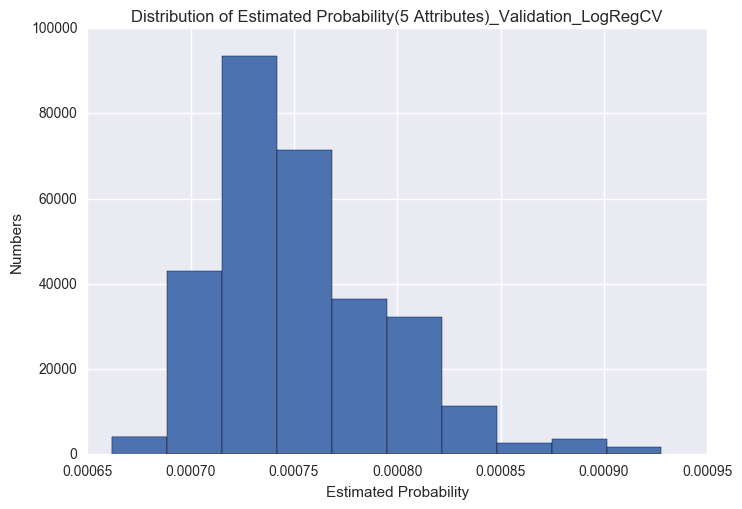

In [92]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
va_df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(5 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

count    299745.000000
mean          0.000753
std           0.000042
min           0.000662
25%           0.000724
50%           0.000745
75%           0.000776
max           0.000928
Name: log_prob, dtype: float64


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


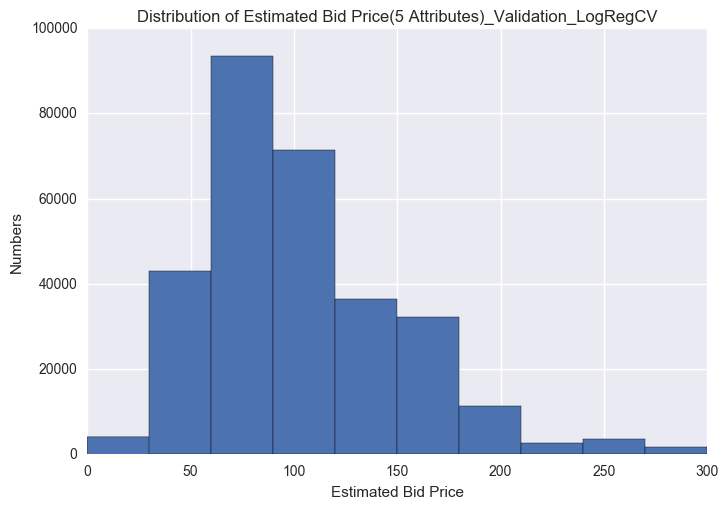

In [93]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(5 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

In [94]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean        103.081761
std          46.873209
min           0.000000
25%          69.781304
50%          93.207950
75%         129.094272
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 2197.097732342728
skewness: 1.010513932582026
kurtosis: 1.1845817391619349


In [95]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


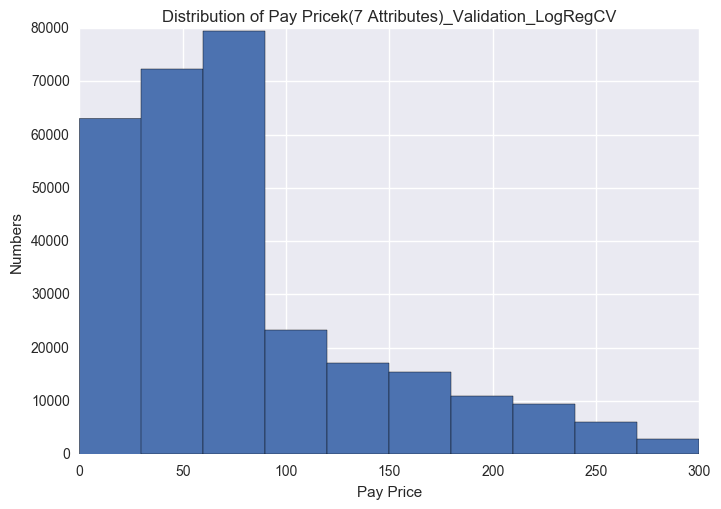

In [96]:
plt.xlabel('Pay Price')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Pay Pricek(7 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

In [97]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


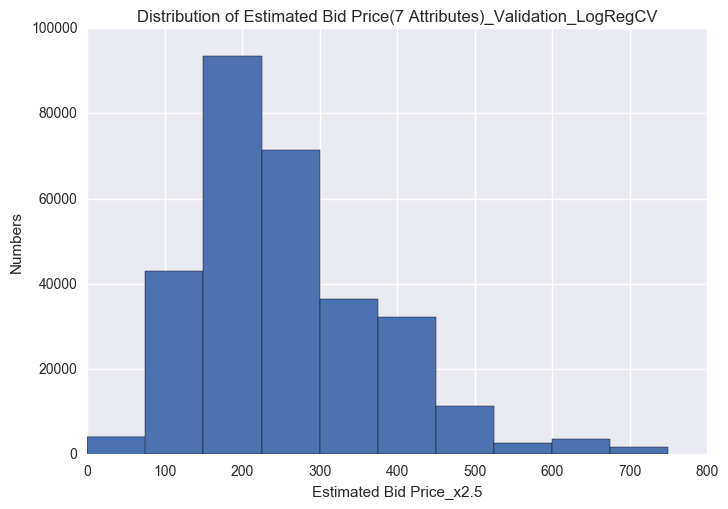

In [98]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_LogRegCV")
plt.legend()
plt.show()

### Tables

In [99]:
impression = va_df[va_df['estimatedBidPrice'] > va_df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [100]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |  195101  | 130 |0.0006663215462760313|
|   estimatedBidPrice_x2.5  |  284522  | 212 |0.0007451093412811663|
| estimatedBidPrice_x2.5_d25|  219474  | 169 | 0.000770022872868768|
| estimatedBidPrice_x2.5_d50|  148916  | 143 |0.0009602729055306347|
|    estimatedBidPrice_x4   |  297139  | 225 |0.0007572213677773702|
|  estimatedBidPrice_linear |  198803  | 106 |0.0005331911490269261|
|estimatedBidPrice_linear_70|  154867  |  63 |0.0004068006741268314|
+---------------------------+----------+-----+---------------------+


In [101]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.7) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d71_5 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.715) )]
click_d71_5 = impression_d71_5[impression_d71_5['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d71_5", impression_d71_5.shape[0], \
           click_d71_5.shape[0], \
           click_d71_5.shape[0]/impression_d71_5.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
| estimatedBidPrice_x2.5_d65 |  104841  | 117 | 0.001115975620224912|
| estimatedBidPrice_x2.5_d70 |  89924   | 109 |0.0012121346915172813|
|estimatedBidPrice_x2.5_d71_5|  85423   | 103 |0.0012057642555283706|
| estimatedBidPrice_x2.5_d75 |  74912   |  93 |0.0012414566424604869|
+----------------------------+----------+-----+---------------------+


In [102]:
impression1 = impression_d70
click1 = impression1[impression1['click'] == 1 ]
cost1 = impression1['payprice'].sum()

In [125]:
a = PrettyTable(["Variable", "Number"])
a.align["Number"] = "1" # Left align  
a.padding_width = 0 # One space between column edges and contents (default)

a.add_row(["Cost", cost1])

                 
a.add_row(["Impression", impression1.shape[0]])
                 
                 
a.add_row(["Click", click1.shape[0]])          
                 
                 
a.add_row(["CTR", click1.shape[0]/impression1.shape[0]])                 
          
               
# avg CPM = cost per thousand impressions
a.add_row(["avg CPM", cost1  /  ( impression1.shape[0] / 1000) ])
                 
                 
# avg CPC = cost per click
a.add_row(["avg CPC", cost1/click1.shape[0]])

In [126]:
print(a)

+----------+---------------------+
| Variable |        Number       |
+----------+---------------------+
|   Cost   |       7825429       |
|Impression|        89924        |
|  Click   |         109         |
|   CTR    |0.0012121346915172813|
| avg CPM  |  87022.69694408611  |
| avg CPC  |  71792.92660550459  |
+----------+---------------------+


## Training Logistic Regression (linear_model.SGDClassifier(loss='log'))

In [104]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [105]:
# Training the model
SGDlog = linear_model.SGDClassifier(loss='log')

In [106]:
SGDlog.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [107]:
SGDlog.score(X_validation, Y_validation)

0.99924602578858701

In [108]:
SGDlog.predict_proba(X_validation)

array([[  9.99997390e-01,   2.60973652e-06],
       [  9.99985066e-01,   1.49337558e-05],
       [  9.99995414e-01,   4.58638406e-06],
       ..., 
       [  9.99945962e-01,   5.40384871e-05],
       [  9.99999473e-01,   5.26774019e-07],
       [  9.99993270e-01,   6.72955457e-06]])

In [109]:
va_df.drop(['log_prob', 'estimatedBidPrice', 'estimatedBidPrice_x2.5', 'estimatedBidPrice_x4', \
            'estimatedBidPrice_linear', 'estimatedBidPrice_linear_70'], axis=1, inplace=True)

In [110]:
probarray = SGDlog.predict_proba(va_df[[col for col in va_df.columns if col not in ['click', 'payprice', 'bidprice']]])
va_df['log_prob'] =probarray[:,1]
probarray

array([[  9.99997390e-01,   2.60973652e-06],
       [  9.99985066e-01,   1.49337558e-05],
       [  9.99995414e-01,   4.58638406e-06],
       ..., 
       [  9.99945962e-01,   5.40384871e-05],
       [  9.99999473e-01,   5.26774019e-07],
       [  9.99993270e-01,   6.72955457e-06]])

count    2.997450e+05
mean     1.331292e-04
std      5.304190e-04
min      7.375400e-10
25%      1.061479e-06
50%      7.752391e-06
75%      6.750853e-05
max      1.562838e-02
Name: log_prob, dtype: float64


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


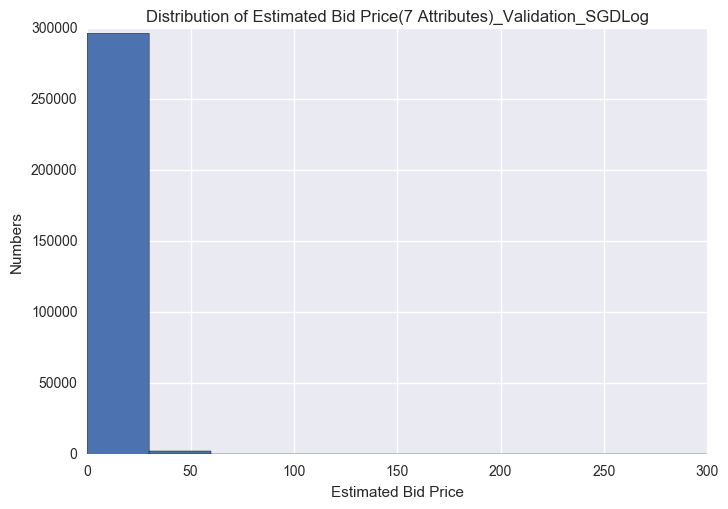

In [111]:
print(va_df['log_prob'].describe())
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice'] = va_df['log_prob'].apply(  lambda x: f(x) )
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
va_df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [112]:
# Information about bid price
print(va_df['estimatedBidPrice'].describe())
print("variance:", va_df['estimatedBidPrice'].var())
print("skewness:", st.skew(va_df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(va_df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean          2.555515
std          10.181844
min           0.000000
25%           0.020362
50%           0.148800
75%           1.295869
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 103.66994993304172
skewness: 12.795741394477089
kurtosis: 225.34693762774162


In [113]:
# Information about pay price
print(va_df['payprice'].describe())
print("variance:", va_df['payprice'].var())
print("skewness:", st.skew(va_df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(va_df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


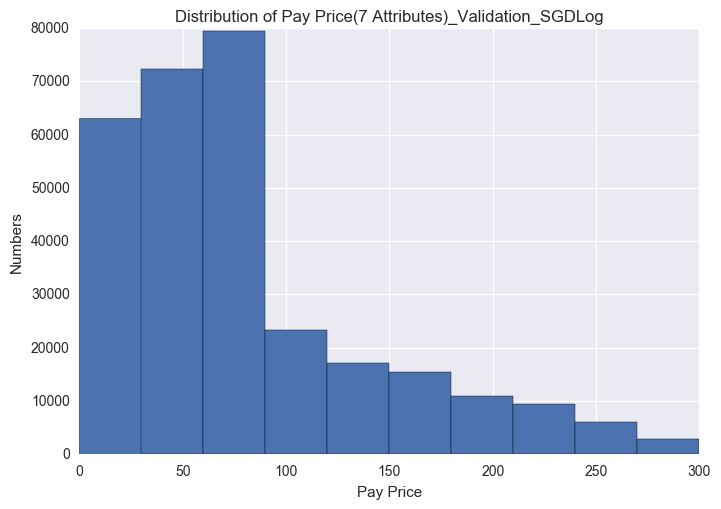

In [114]:
plt.xlabel('Pay Price')
plt.ylabel('Numbers')
va_df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Pay Price(7 Attributes)_Validation_SGDLog")
plt.legend()
plt.show()

In [115]:
f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x2.5'] = va_df['log_prob'].apply(  lambda x: f(x)*2.5 )

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


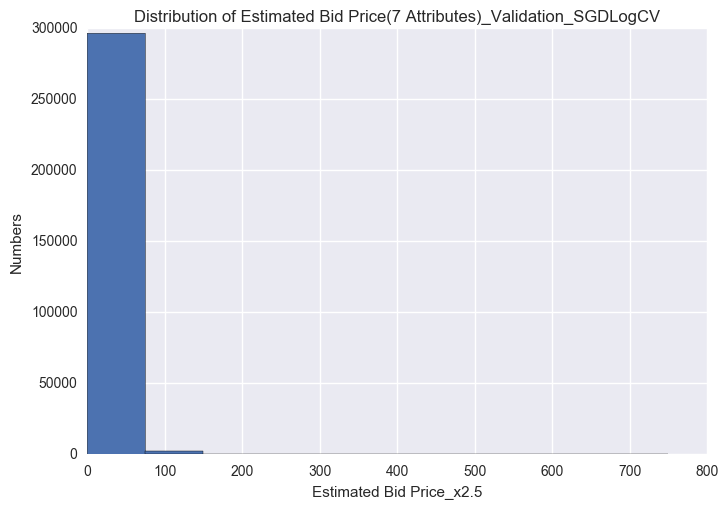

In [116]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
va_df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(7 Attributes)_Validation_SGDLogCV")
plt.legend()
plt.show()

### Table

In [117]:
impression = va_df[(va_df['estimatedBidPrice'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0) )]
click = impression[impression['click'] == 1 ]

impression_x2 = va_df[va_df['estimatedBidPrice_x2.5'] > va_df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.5) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

f = interpolate.interp1d( [min(va_df['log_prob']) , max(va_df['log_prob'])], [min(va_df['payprice']), max(va_df['payprice']) ])
va_df['estimatedBidPrice_x4'] = va_df['log_prob'].apply(  lambda x: f(x)*4 )

impression_x4 = va_df[va_df['estimatedBidPrice_x4'] > va_df['payprice']]
click_x4 = impression_x4[impression_x4['click'] == 1 ]

va_df['estimatedBidPrice_linear'] = va_df['log_prob'] * 84 / 2034 * 2697738

impression_linear = va_df[va_df['estimatedBidPrice_linear'] > va_df['payprice']]
click_linear = impression_linear[impression_linear['click'] == 1 ]

va_df['estimatedBidPrice_linear_70'] = va_df['log_prob'] * 70 / 2034 * 2697738
impression_linear_70 = va_df[va_df['estimatedBidPrice_linear_70'] > va_df['payprice']]
click_linear_70 = impression_linear_70[impression_linear_70['click'] == 1 ]

In [118]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x4", impression_x4.shape[0], \
           click_x4.shape[0], \
           click_x4.shape[0]/impression_x4.shape[0]])

x.add_row(["estimatedBidPrice_linear", impression_linear.shape[0], \
           click_linear.shape[0], \
           click_linear.shape[0]/impression_linear.shape[0]])

x.add_row(["estimatedBidPrice_linear_70", impression_linear_70.shape[0], \
           click_linear_70.shape[0], \
           click_linear_70.shape[0]/impression_linear_70.shape[0]])

print(x)

+---------------------------+----------+-----+---------------------+
|          Variable         |Impression|Click|         CTR         |
+---------------------------+----------+-----+---------------------+
|     estimatedBidPrice     |   3718   |  6  |0.0016137708445400753|
|   estimatedBidPrice_x2.5  |   9690   |  10 |0.0010319917440660474|
| estimatedBidPrice_x2.5_d25|   9685   |  10 |0.0010325245224574084|
| estimatedBidPrice_x2.5_d50|   9673   |  10 | 0.001033805437816603|
|    estimatedBidPrice_x4   |  15294   |  12 |0.0007846214201647705|
|  estimatedBidPrice_linear |  21361   |  19 |0.0008894714666916343|
|estimatedBidPrice_linear_70|  18114   |  12 | 0.000662471016893011|
+---------------------------+----------+-----+---------------------+


In [119]:
impression_d65 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.65) )]
click_d65 = impression_d65[impression_d65['click'] == 1 ]

impression_d70 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.70) )]
click_d70 = impression_d70[impression_d70['click'] == 1 ]

impression_d75 = va_df[(va_df['estimatedBidPrice_x2.5'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

y = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
y.align["Impression"] = "1" # Left align city names 
y.padding_width = 0 # One space between column edges and contents (default)

y.add_row(["estimatedBidPrice_x2.5_d65", impression_d65.shape[0], \
           click_d65.shape[0], \
           click_d65.shape[0]/impression_d65.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d70", impression_d70.shape[0], \
           click_d70.shape[0], \
           click_d70.shape[0]/impression_d70.shape[0]])

y.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(y)

+--------------------------+----------+-----+---------------------+
|         Variable         |Impression|Click|         CTR         |
+--------------------------+----------+-----+---------------------+
|estimatedBidPrice_x2.5_d65|   9651   |  10 |0.0010361620557455186|
|estimatedBidPrice_x2.5_d70|   9636   |  10 |0.0010377750103777502|
|estimatedBidPrice_x2.5_d75|   9609   |  10 |0.0010406910188365075|
+--------------------------+----------+-----+---------------------+


In [120]:
log_prob_list = va_df['log_prob'].tolist()
va_df.log_prob.describe()
for i in range(len(log_prob_list)):
    if log_prob_list[i] > 0.000765:
    # if log_prob_list[i] > va_df.log_prob.quantile(0.75): 
        log_prob_list[i] *= 3.5
    elif 0.000765> log_prob_list[i] > 0.000752  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.5):
        log_prob_list[i] *=3
        
    elif 0.000752> log_prob_list[i] > 0.000740  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0.25):
        log_prob_list[i] *=0.2
        
    elif 0.000740> log_prob_list[i] > 0.000695  :
    # elif log_prob_list[i] > va_df.log_prob.quantile(0):
        log_prob_list[i] *=0.1   
        
va_df['estimatedBidPrice_linear2'] = pd.DataFrame(log_prob_list) * 84 / 2034 * 2697738
impression_linear2 = va_df[(va_df['estimatedBidPrice_linear2'] > va_df['payprice']) & (va_df['log_prob'] > va_df['log_prob'].quantile(0.40) )]
click_linear2 = impression_linear2[impression_linear2['click'] == 1 ]        
               
z = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
z.align["Impression"] = "1" # Left align city names 
z.padding_width = 0 # One space between column edges and contents (default)

z.add_row(["estimatedBidPrice_linear2", impression_linear2.shape[0], \
           click_linear2.shape[0], \
           click_linear2.shape[0]/impression_linear2.shape[0]])

print(z)

+-------------------------+----------+-----+---------------------+
|         Variable        |Impression|Click|         CTR         |
+-------------------------+----------+-----+---------------------+
|estimatedBidPrice_linear2|  14360   |  10 |0.0006963788300835655|
+-------------------------+----------+-----+---------------------+


## Lasso

In [121]:
clf = linear_model.Lasso(alpha = 0.1)

In [122]:
clf.fit(X, Y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
clf.score(X_validation, Y_validation)

-3.6060043839825084e-13